<a href="https://colab.research.google.com/github/MIKhailkomkin/movie-recsys/blob/main/film_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Обработка данных

In [2]:
movies_data = pd.read_csv('/content/movies.csv')

In [3]:
movies_data.sample(5)

,Unnamed: 0,id,title,overview,release_date,popularity,vote_average,vote_count
6982,6982,8398,The Hitcher,While driving through the New Mexico Desert du...,2007-01-19,11.417,5.9,626
3379,3379,84332,Safety Not Guaranteed,Three magazine employees head out on an assign...,2012-06-08,10.898,6.8,1014
2817,2817,178682,The Wizards Return: Alex vs. Alex,The Russo family and friends are headed to Tus...,2013-03-15,16.780,7.0,533
7815,7815,10878,Saving Silverman,A pair of buddies conspire to save their best ...,2001-02-09,14.192,5.5,366
5847,5847,69798,The Inbetweeners Movie,High school graduation just wouldn’t be comple...,2011-08-19,9.536,6.2,666


In [4]:
movies_data.drop(columns=['vote_count'], inplace=True)

In [5]:
movies_data.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
movies_data.isna().sum()

,0
id,0
title,0
overview,20
release_date,0
popularity,0
vote_average,0


In [7]:
movies_data['overview'].fillna(' ', inplace=True)

<ipython-input-7-4f966d7421b7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_data['overview'].fillna(' ', inplace=True)


In [8]:
movies_data.isna().sum()

,0
id,0
title,0
overview,0
release_date,0
popularity,0
vote_average,0


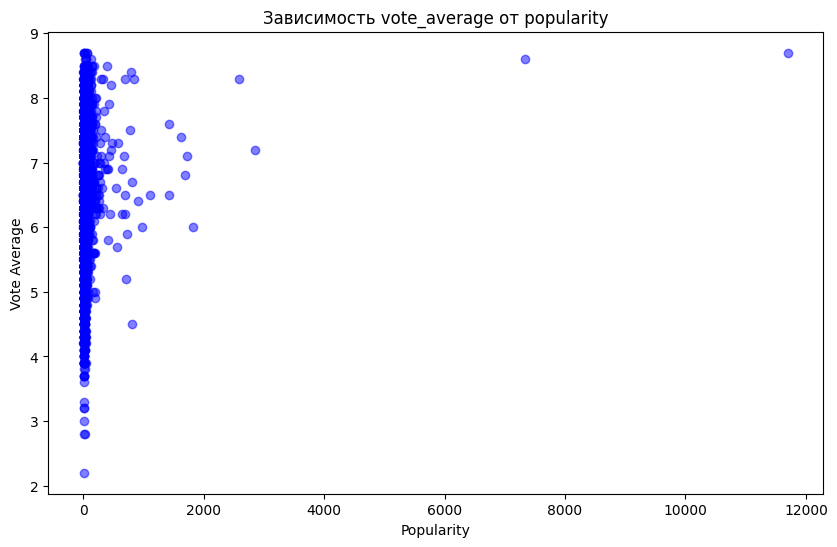

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(movies_data['popularity'], movies_data['vote_average'], alpha=0.5, color='b')

plt.title('Зависимость vote_average от popularity')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')

plt.show()


видно что существует определенное кол-во выбросов

In [10]:
movies_data['popularity'].median()

13.217

In [11]:
movies_data['popularity'].mean()

26.87021716758274

In [12]:
threshold = 1000
movies_data = movies_data[movies_data['popularity'] <= threshold]

еще раз графики

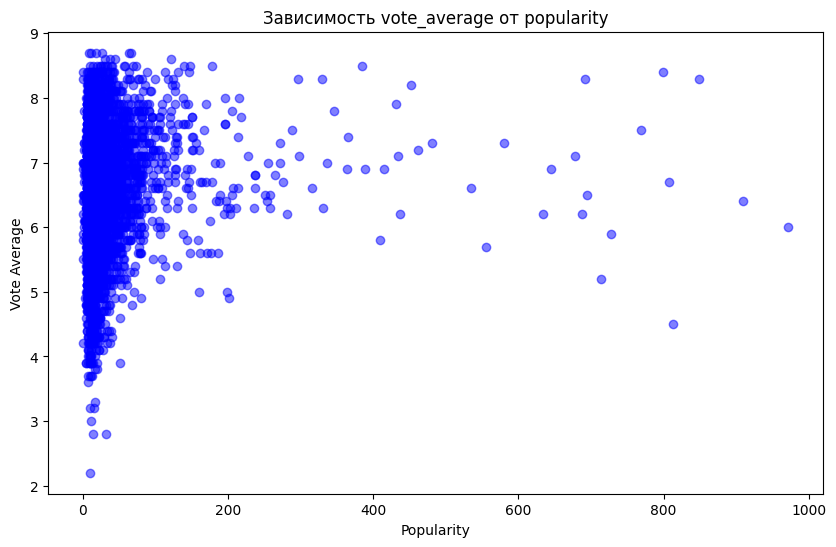

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(movies_data['popularity'], movies_data['vote_average'], alpha=0.5, color='b')

plt.title('Зависимость vote_average от popularity')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')

plt.show()


In [ ]:
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'], format='%Y-%m-%d')

In [ ]:
movies_data['year'] = movies_data['release_date'].dt.year #скорее всего для рекомендаций важен только год
movies_data['month'] = movies_data['release_date'].dt.month #на всякий случай можно оставить месяц

In [ ]:
movies_data.drop(columns = ['release_date'], inplace=True)

# BERT для обработки описаний фильмов

In [14]:
from sentence_transformers import SentenceTransformer


In [15]:
model = SentenceTransformer("all-MiniLM-L6-v2")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
def get_emb(text):
    return model.encode(text)

In [17]:
movies_data['overview_emb'] = list(model.encode(movies_data['overview'].fillna("").tolist(), batch_size=64, show_progress_bar=True))
movies_data.drop(columns=['overview'], inplace= True)

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

In [18]:
movies_data['title_emb'] = list(model.encode(movies_data['title'].fillna("").tolist(), batch_size=64, show_progress_bar=True))
movies_data.drop(columns=['title'], inplace= True)

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

In [20]:
movies_data.sample(5)

,id,release_date,popularity,vote_average,overview_emb,title_emb
0,19404,1995-10-20,18.433,8.7,"[-0.0412922, 0.04202319, -0.037427228, 0.05324...","[-0.044276383, 0.1093827, 0.07794347, 0.000949..."
1,724089,2020-07-31,8.439,8.7,"[-0.035351705, -0.014911776, -0.024249962, 0.0...","[-0.07532811, 0.10374771, -0.023120472, -0.000..."
2,278,1994-09-23,65.570,8.7,"[-0.037536923, -0.044025708, -0.06706974, -0.0...","[-0.07702803, 0.004889834, -0.034960195, 0.024..."
3,238,1972-03-14,63.277,8.7,"[-0.07444193, 0.06918566, -0.056934215, -0.032...","[-0.122525595, 0.0011337912, -0.09568716, 0.05..."
4,761053,2020-11-19,26.691,8.7,"[-0.0323812, -0.024419272, -0.01553815, 0.0078...","[-0.08347525, 0.09752586, -0.021734534, 0.0040..."
...,...,...,...,...,...,...
8546,13805,2008-08-29,14.630,3.2,"[-0.057667796, -0.06657503, -0.0023217713, 0.0...","[-0.042355828, 0.009898093, -0.0144228265, 0.0..."
8547,5491,2000-05-12,10.647,3.0,"[-0.09920912, 0.096830755, -0.016629096, 0.003...","[-0.040558483, 0.015028733, 0.005308866, -0.10..."
8548,14164,2009-03-12,32.244,2.8,"[-0.03911484, 0.10326468, -0.06785061, 0.01454...","[-0.12422254, 0.06635345, -0.005183879, -0.005..."
8549,11059,2003-04-11,14.502,2.8,"[-0.0462871, 0.0063592615, -0.031834107, -0.11...","[-0.04472689, -0.0014929484, -0.09435263, -0.0..."


In [21]:
overview_emb_columns = [f'overview_emb_{i}' for i in range(len(movies_data['overview_emb'][0]))]
title_emb_columns = [f'title_emb_{i}' for i in range(len(movies_data['title_emb'][0]))]

movies_data[overview_emb_columns] = pd.DataFrame(movies_data['overview_emb'].tolist(), index=movies_data.index)
movies_data[title_emb_columns] = pd.DataFrame(movies_data['title_emb'].tolist(), index=movies_data.index)

print(movies_data.head())

<ipython-input-21-b76b4bf30aac>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movies_data[overview_emb_columns] = pd.DataFrame(movies_data['overview_emb'].tolist(), index=movies_data.index)
<ipython-input-21-b76b4bf30aac>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movies_data[overview_emb_columns] = pd.DataFrame(movies_data['overview_emb'].tolist(), index=movies_data.index)
<ipython-input-21-b76b4bf30aac>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

       id release_date  popularity  vote_average  \
0   19404   1995-10-20      18.433           8.7   
1  724089   2020-07-31       8.439           8.7   
2     278   1994-09-23      65.570           8.7   
3     238   1972-03-14      63.277           8.7   
4  761053   2020-11-19      26.691           8.7   

                                        overview_emb  \
0  [-0.0412922, 0.04202319, -0.037427228, 0.05324...   
1  [-0.035351705, -0.014911776, -0.024249962, 0.0...   
2  [-0.037536923, -0.044025708, -0.06706974, -0.0...   
3  [-0.07444193, 0.06918566, -0.056934215, -0.032...   
4  [-0.0323812, -0.024419272, -0.01553815, 0.0078...   

                                           title_emb  overview_emb_0  \
0  [-0.044276383, 0.1093827, 0.07794347, 0.000949...       -0.041292   
1  [-0.07532811, 0.10374771, -0.023120472, -0.000...       -0.035352   
2  [-0.07702803, 0.004889834, -0.034960195, 0.024...       -0.037537   
3  [-0.122525595, 0.0011337912, -0.09568716, 0.05...       -0.

<ipython-input-21-b76b4bf30aac>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movies_data[title_emb_columns] = pd.DataFrame(movies_data['title_emb'].tolist(), index=movies_data.index)
<ipython-input-21-b76b4bf30aac>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movies_data[title_emb_columns] = pd.DataFrame(movies_data['title_emb'].tolist(), index=movies_data.index)
<ipython-input-21-b76b4bf30aac>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

In [28]:
movies_data.drop(columns=['overview_emb', 'title_emb'], inplace=True)

на этом этапе модель может предсказывать средний рейтинг фильма, полученный от всех пользоватей

# Сгенерируем данные о пользователях.

Существующие датасеты фильм + пользователь слишком большие, чтобы была возможность так подробно с ними работать

In [32]:
movies = movies_data[['id', 'popularity', 'vote_average']]

num_users = 10000

users = pd.DataFrame({'user_id': range(1, num_users + 1)})

num_clusters = 10
movies['cluster'] = np.random.randint(0, num_clusters, size=len(movies))  # кластеризуем

def generate_interactions(users, movies, max_movies_per_user=100):
    interactions = []
    for user_id in users['user_id']:
        num_movies = np.random.randint(20, max_movies_per_user)  # Сколько фильмов посмотрел пользователь
        user_cluster = np.random.randint(0, num_clusters)  # У каждого пользователя есть свои предпочтения
        user_movies = movies[movies['cluster'] == user_cluster].sample(n=num_movies, replace=True)  # Выбираем фильмы из кластера

        for _, movie in user_movies.iterrows():
            rating = np.clip(np.random.normal(loc=movie['vote_average'], scale=1.5), 1, 10)  # Генерируем оценку
            watched = 1
            liked = 1 if rating > 7 else 0  # Лайк, если рейтинг высокий
            interactions.append((user_id, movie['id'], rating, watched, liked))

    return pd.DataFrame(interactions, columns=['user_id', 'movie_id', 'rating', 'watched', 'liked'])

<ipython-input-32-091ac20c8347>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['cluster'] = np.random.randint(0, num_clusters, size=len(movies))  # Простая кластеризация


   user_id  movie_id    rating  watched  liked
0        1   10757.0  6.321037        1      0
1        1   10760.0  3.625545        1      0
2        1  546554.0  7.646655        1      1
3        1  429351.0  6.594896        1      0
4        1  332567.0  3.577508        1      0


In [ ]:
def generate_interactions(users, movies, max_movies_per_user=100): # функция для генерации синтетических данных
    interactions = []
    for user_id in users['user_id']:
        num_movies = np.random.randint(20, max_movies_per_user)  # сколько фильмов посмотрел пользователь
        user_cluster = np.random.randint(0, num_clusters)  # предпочтения пользователя
        user_movies = movies[movies['cluster'] == user_cluster].sample(n=num_movies, replace=True)  # выбираем фильмы из кластера

        for _, movie in user_movies.iterrows():
            rating = np.clip(np.random.normal(loc=movie['vote_average'], scale=1.5), 1, 10)  # генерируя оценку, используем нормальное распределение
            watched = 1
            liked = 1 if rating > 7 else 0  # в понравившиеся, если оценка фильма > 7
            interactions.append((user_id, movie['id'], rating, watched, liked))

    return pd.DataFrame(interactions, columns=['user_id', 'movie_id', 'rating', 'watched', 'liked'])

In [ ]:
interactions = generate_interactions(users, movies)
interactions.to_csv('synthetic_user_movie_data.csv', index=False) # сохраняем

In [33]:
interactions.sample(5)

,user_id,movie_id,rating,watched,liked
579180,9745,513409.0,7.453184,1,1
72027,1221,2360.0,7.030917,1,1
82122,1391,13252.0,4.602094,1,0
452471,7597,451499.0,10.000000,1,1
129427,2186,53174.0,8.769205,1,1


In [34]:
interactions.dtypes

,0
user_id,int64
movie_id,float64
rating,float64
watched,int64
liked,int64


In [35]:
interactions['movie_id'] = interactions['movie_id'].apply(int)

# построим эмбендинг пользователей и фильмов

обучаем svd на датасете пользователь-оценка фильма
чтобы получить колаборативные эмбединги фильмов и пользователей \\
после этого передаем их вместе с данными о фильме в кэтбуст
кэтбуст получает как колаборативные так и контент based признаки
-> гибридный метод


In [37]:
!pip install surprise
from surprise import SVD, Dataset, Reader

In [38]:
df = interactions

In [ ]:
reader = Reader(rating_scale=(df["rating"].min(), df["rating"].max()))
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']], reader)
trainset = data.build_full_trainset()

model = SVD(n_factors=50, n_epochs=20, random_state=42)
model.fit(trainset)

In [ ]:
user_embeddings = {trainset.to_raw_uid(u): model.pu[u] for u in trainset.all_users()} # получим эмбендиги пользователей и фильмов
movie_embeddings = {trainset.to_raw_iid(i): model.qi[i] for i in trainset.all_items()}

In [ ]:
user_df = pd.DataFrame.from_dict(user_embeddings, orient='index')
user_df.columns = [f"user_svd_{i}" for i in range(user_df.shape[1])]
user_df.index.name = "user_id"

movie_df = pd.DataFrame.from_dict(movie_embeddings, orient='index')
movie_df.columns = [f"movie_svd_{i}" for i in range(movie_df.shape[1])]
movie_df.index.name = "movie_id"

In [ ]:
# сохраняем файлами
user_df.to_csv("user_embeddings.csv")
movie_df.to_csv("movie_embeddings.csv")

In [39]:
movies_data.rename(columns={'id':'movie_id'}, inplace = True)

In [40]:
movie_df.head(5)

,movie_svd_0,movie_svd_1,movie_svd_2,movie_svd_3,movie_svd_4,movie_svd_5,movie_svd_6,movie_svd_7,movie_svd_8,movie_svd_9,...,movie_svd_40,movie_svd_41,movie_svd_42,movie_svd_43,movie_svd_44,movie_svd_45,movie_svd_46,movie_svd_47,movie_svd_48,movie_svd_49
movie_id,,,,,,,,,,,,,,,,,,,,,
10757,-0.151944,-0.084583,0.091959,0.050540,-0.145804,-0.132964,0.099824,-0.276817,0.139817,0.118902,...,-0.309204,-0.190426,-0.038210,-0.058885,-0.027638,0.206195,0.062331,0.037709,0.368871,0.190089
10760,-0.318800,0.209426,-0.107274,-0.139021,-0.399832,0.204942,0.193235,0.132642,-0.364711,-0.094152,...,-0.425417,-0.067158,0.336471,-0.282305,0.421370,-0.241776,0.113809,-0.141418,0.272790,-0.040827
546554,-0.301209,0.040182,0.000818,-0.227191,0.104431,-0.180452,-0.050124,-0.165466,-0.014427,-0.073629,...,0.102028,-0.162851,-0.178746,0.059491,-0.002950,0.135577,-0.123856,0.064950,0.259190,0.085156
429351,-0.298649,-0.085988,0.422710,0.019110,0.132781,-0.110618,0.112394,-0.480958,-0.138353,-0.131595,...,-0.189447,0.351674,-0.029912,0.267902,0.045288,-0.137577,-0.070360,-0.051182,-0.079295,-0.197034
332567,0.023754,-0.074478,-0.270515,-0.179380,-0.099316,0.065512,0.215813,-0.001040,0.175206,0.128679,...,-0.319823,0.314531,-0.021893,-0.049004,0.103166,-0.040837,-0.130496,-0.092203,-0.048239,-0.005164


In [41]:
user_df.head(5)

,user_svd_0,user_svd_1,user_svd_2,user_svd_3,user_svd_4,user_svd_5,user_svd_6,user_svd_7,user_svd_8,user_svd_9,...,user_svd_40,user_svd_41,user_svd_42,user_svd_43,user_svd_44,user_svd_45,user_svd_46,user_svd_47,user_svd_48,user_svd_49
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.374118,-0.038759,0.116312,0.338571,-0.032513,0.070196,0.386082,0.012573,-0.127622,-0.123657,...,0.104723,-0.132441,-0.066868,0.137253,-0.238522,-0.188260,0.029922,0.157791,-0.123536,-0.372514
2,0.336882,0.111453,-0.145756,0.429433,0.033305,-0.020136,-0.227618,-0.167846,0.298941,-0.162302,...,-0.107062,0.228582,0.128790,-0.223014,-0.064527,-0.354958,-0.127917,-0.119264,0.104898,0.055662
3,-0.467860,-0.204008,-0.034926,-0.071018,-0.038583,0.046930,0.354452,0.090481,0.026889,0.091917,...,0.211781,0.176005,-0.085069,-0.125314,-0.056490,0.123269,-0.140168,0.043416,0.199641,-0.192382
4,-0.302617,0.003008,-0.183274,-0.129326,0.144070,-0.133663,0.439378,0.169974,-0.267721,0.177418,...,0.051518,-0.101596,-0.150296,0.005232,0.386391,0.260636,-0.246494,-0.095413,0.000354,-0.119056
5,-0.275901,-0.010309,0.332735,0.207322,-0.164442,0.106974,0.196787,-0.003237,0.117993,0.543625,...,-0.056037,-0.137012,0.010303,0.066499,-0.038889,-0.482457,-0.108426,-0.254017,0.436437,0.028390


In [42]:
interactions.head(5)

,user_id,movie_id,rating,watched,liked
0,1,10757,6.321037,1,0
1,1,10760,3.625545,1,0
2,1,546554,7.646655,1,1
3,1,429351,6.594896,1,0
4,1,332567,3.577508,1,0


In [43]:
df_merged_users = interactions.merge(user_df, on='user_id', how='left')

In [44]:
df_merged_users.head(5)

,user_id,movie_id,rating,watched,liked,user_svd_0,user_svd_1,user_svd_2,user_svd_3,user_svd_4,...,user_svd_40,user_svd_41,user_svd_42,user_svd_43,user_svd_44,user_svd_45,user_svd_46,user_svd_47,user_svd_48,user_svd_49
0,1,10757,6.321037,1,0,0.374118,-0.038759,0.116312,0.338571,-0.032513,...,0.104723,-0.132441,-0.066868,0.137253,-0.238522,-0.18826,0.029922,0.157791,-0.123536,-0.372514
1,1,10760,3.625545,1,0,0.374118,-0.038759,0.116312,0.338571,-0.032513,...,0.104723,-0.132441,-0.066868,0.137253,-0.238522,-0.18826,0.029922,0.157791,-0.123536,-0.372514
2,1,546554,7.646655,1,1,0.374118,-0.038759,0.116312,0.338571,-0.032513,...,0.104723,-0.132441,-0.066868,0.137253,-0.238522,-0.18826,0.029922,0.157791,-0.123536,-0.372514
3,1,429351,6.594896,1,0,0.374118,-0.038759,0.116312,0.338571,-0.032513,...,0.104723,-0.132441,-0.066868,0.137253,-0.238522,-0.18826,0.029922,0.157791,-0.123536,-0.372514
4,1,332567,3.577508,1,0,0.374118,-0.038759,0.116312,0.338571,-0.032513,...,0.104723,-0.132441,-0.066868,0.137253,-0.238522,-0.18826,0.029922,0.157791,-0.123536,-0.372514


In [45]:
df_merged_movies = movies_data.merge(movie_df, on='movie_id', how='left')

In [47]:
df = df_merged_users.merge(df_merged_movies, on='movie_id', how='left') # соединяем в один датасет для передачи в catboost

# Модель для предсказаний

In [48]:
!pip install catboost

In [49]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

0:	learn: 1.6250753	test: 1.6187209	best: 1.6187209 (0)	total: 1.28s	remaining: 21m 23s
100:	learn: 0.9524507	test: 0.9486157	best: 0.9486157 (100)	total: 2m 18s	remaining: 20m 30s
200:	learn: 0.9290015	test: 0.9257733	best: 0.9257733 (200)	total: 4m 41s	remaining: 18m 37s
300:	learn: 0.9040731	test: 0.9012781	best: 0.9012781 (300)	total: 7m 6s	remaining: 16m 31s
400:	learn: 0.8812723	test: 0.8794429	best: 0.8794429 (400)	total: 9m 32s	remaining: 14m 14s
500:	learn: 0.8625825	test: 0.8616211	best: 0.8616211 (500)	total: 11m 52s	remaining: 11m 50s
600:	learn: 0.8473141	test: 0.8473591	best: 0.8473591 (600)	total: 14m 10s	remaining: 9m 24s
700:	learn: 0.8333414	test: 0.8340751	best: 0.8340751 (700)	total: 16m 27s	remaining: 7m 1s
800:	learn: 0.8232605	test: 0.8248539	best: 0.8248539 (800)	total: 18m 42s	remaining: 4m 38s
900:	learn: 0.8141929	test: 0.8166333	best: 0.8166333 (900)	total: 20m 54s	remaining: 2m 17s
999:	learn: 0.8055640	test: 0.8088329	best: 0.8088329 (999)	total: 23m 6s	re

In [ ]:
X = df.drop(columns=['rating', 'release_date'])
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X # удаление для освобождения памяти
del y

In [ ]:
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, loss_function='RMSE', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

In [50]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [51]:
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

0.6506613083588367
0.6542106007215521
0.8088328632798942
0.7664822644098859
